In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import math
import sklearn
import sklearn.datasets

from utils import load_params_and_grads, initialize_parameters, forward_propagation, backward_propagation
from utils import compute_cost, predict, predict_dec, plot_decision_boundary, load_dataset


%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

### 1) Gradient Descent
A simple optimization method in machine learning is gradient descent (GD). When you take gradient steps with respect to all $m$ examples on each step, it is also called Batch Gradient Descent. 
$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]} \tag{1}$$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} \tag{2}$$

In [2]:
def update_parameters_with_gd(parameters, grads, learning_rate):
    L = len(parameters) // 2 # number of layers in the neural networks

    # Update rule for each parameter
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads['dW' + str(l+1)] 
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads['db' + str(l+1)]
        
    return parameters

### 2)Mini-Batch Gradient descent

Let's learn how to build mini-batches from the training set (X, Y).

There are two steps:
- **Shuffle**: Create a shuffled version of the training set (X, Y) as shown below. Each column of X and Y represents a training example. Note that the random shuffling is done synchronously between X and Y. Such that after the shuffling the $i^{th}$ column of X is the example corresponding to the $i^{th}$ label in Y. The shuffling step ensures that examples will be split randomly into different mini-batches. 

- **Partition**: Partition the shuffled (X, Y) into mini-batches of size `mini_batch_size` (here 64). Note that the number of training examples is not always divisible by `mini_batch_size`. The last mini batch might be smaller, but you don't need to worry about this. When the final mini-batch is smaller than the full `mini_batch_size`, it will look like this: 


In [3]:

def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    
    np.random.seed(seed)            # To make your "random" minibatches the same as ours
    m = X.shape[1]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1,m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
    
        mini_batch_X = shuffled_X[:, k*mini_batch_size : (k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k*mini_batch_size : (k+1)*mini_batch_size]
    
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:,num_complete_minibatches * mini_batch_size:]
        mini_batch_Y = shuffled_Y[:,num_complete_minibatches * mini_batch_size:]
    
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

### 3) Momentum
Because mini-batch gradient descent makes a parameter update after seeing just a subset of examples, the direction of the update has some variance, and so the path taken by mini-batch gradient descent will "oscillate" toward convergence. Using momentum can reduce these oscillations. 

In [4]:
# GRADED FUNCTION: initialize_velocity

def initialize_velocity(parameters):
    
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    
    # Initialize velocity
    for l in range(L):
        v["dW" + str(l+1)] = np.zeros_like(parameters['W' + str(l+1)])
        v["db" + str(l+1)] = np.zeros_like(parameters['b' + str(l+1)])
        
    return v

In [5]:
# GRADED FUNCTION: update_parameters_with_momentum

def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate):
   
    L = len(parameters) // 2 # number of layers in the neural networks
    
    # Momentum update for each parameter
    for l in range(L):
        # compute velocities
        v["dW" + str(l+1)] = beta * v["dW" + str(l+1)] + (1-beta) * grads['dW' + str(l+1)]
        v["db" + str(l+1)] = beta * v["db" + str(l+1)] + (1-beta) * grads['db' + str(l+1)]
        # update parameters
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * v['dW' + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * v['db' + str(l+1)]
        
        
    return parameters, v

### 4) Adam
Adam is one of the most effective optimization algorithms for training neural networks. It combines ideas from RMSProp (described in lecture) and Momentum. 


The update rule is, for $l = 1, ..., L$: 

$$\begin{cases}
v_{dW^{[l]}} = \beta_1 v_{dW^{[l]}} + (1 - \beta_1) \frac{\partial \mathcal{J} }{ \partial W^{[l]} } \\
v^{corrected}_{dW^{[l]}} = \frac{v_{dW^{[l]}}}{1 - (\beta_1)^t} \\
s_{dW^{[l]}} = \beta_2 s_{dW^{[l]}} + (1 - \beta_2) (\frac{\partial \mathcal{J} }{\partial W^{[l]} })^2 \\
s^{corrected}_{dW^{[l]}} = \frac{s_{dW^{[l]}}}{1 - (\beta_1)^t} \\
W^{[l]} = W^{[l]} - \alpha \frac{v^{corrected}_{dW^{[l]}}}{\sqrt{s^{corrected}_{dW^{[l]}}} + \varepsilon}
\end{cases}$$
where:
- t counts the number of steps taken of Adam 
- L is the number of layers
- $\beta_1$ and $\beta_2$ are hyperparameters that control the two exponentially weighted averages. 
- $\alpha$ is the learning rate
- $\varepsilon$ is a very small number to avoid dividing by zero


In [6]:
# GRADED FUNCTION: initialize_adam

def initialize_adam(parameters) :
    
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}
    
    # Initialize v, s. Input: "parameters". Outputs: "v, s".
    for l in range(L):
        v["dW" + str(l + 1)] = np.zeros_like(parameters["W" + str(l + 1)])
        v["db" + str(l + 1)] = np.zeros_like(parameters["b" + str(l + 1)])
        s["dW" + str(l+1)] = np.zeros_like(parameters["W" + str(l + 1)])
        s["db" + str(l+1)] = np.zeros_like(parameters["b" + str(l + 1)])
    
    return v, s

In [7]:
# GRADED FUNCTION: update_parameters_with_adam

def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    
    L = len(parameters) // 2                 # number of layers in the neural networks
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    s_corrected = {}                         # Initializing second moment estimate, python dictionary
    
    # Perform Adam update on all parameters
    for l in range(L):
        # Moving average of the gradients. Inputs: "v, grads, beta1". Output: "v".
        v["dW" + str(l + 1)] = beta1 * v["dW" + str(l + 1)] + (1 - beta1) * grads['dW' + str(l + 1)]
        v["db" + str(l + 1)] = beta1 * v["db" + str(l + 1)] + (1 - beta1) * grads['db' + str(l + 1)]

        # Compute bias-corrected first moment estimate. Inputs: "v, beta1, t". Output: "v_corrected".
        v_corrected["dW" + str(l + 1)] = v["dW" + str(l + 1)] / (1 - beta1**t)
        v_corrected["db" + str(l + 1)] = v["db" + str(l + 1)] / (1 - beta1**t)

        # Moving average of the squared gradients. Inputs: "s, grads, beta2". Output: "s".
        s["dW" + str(l + 1)] = beta2 * s["dW" + str(l + 1)] + (1 - beta2) * grads['dW' + str(l + 1)]**2
        s["db" + str(l + 1)] = beta2 * s["db" + str(l + 1)] + (1 - beta2) * grads['db' + str(l + 1)]**2

        # Compute bias-corrected second raw moment estimate. Inputs: "s, beta2, t". Output: "s_corrected".
    
        s_corrected["dW" + str(l + 1)] = s["dW" + str(l + 1)] / (1 - beta2**t)
        s_corrected["db" + str(l + 1)] = s["db" + str(l + 1)] / (1 - beta2**t)


        # Update parameters. Inputs: "parameters, learning_rate, v_corrected, s_corrected, epsilon". Output: "parameters".
    
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * v_corrected["dW" + str(l + 1)] / (np.sqrt(s_corrected["dW" + str(l + 1)]) + epsilon)
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * v_corrected["db" + str(l + 1)] / (np.sqrt(s_corrected["db" + str(l + 1)]) + epsilon)
    

    return parameters, v, s

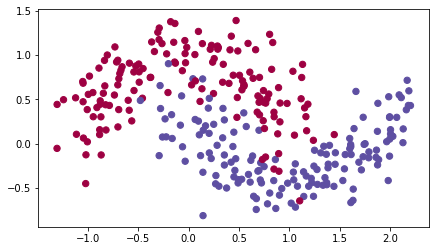

In [8]:
train_X, train_Y = load_dataset()

In [9]:
train_X.shape

(2, 300)

In [10]:
train_Y.shape

(1, 300)

### Model with different optimization algorithms

In [13]:
def model(X, Y, layers_dims, optimizer, learning_rate = 0.0007, mini_batch_size = 64, beta = 0.9,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 20000, print_cost = True):
    
    L = len(layers_dims)             # number of layers in the neural networks
    costs = []                       # to keep track of the cost
    t = 0                            # initializing the counter required for Adam update
    seed = 10                        # For grading purposes, so that your "random" minibatches are the same as ours
    # Initialize parameters
    parameters = initialize_parameters(layers_dims)

    # Initialize the optimizer
    if optimizer == "gd":
        pass # no initialization required for gradient descent
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)
    
    # Optimization loop
    for i in range(num_epochs):

        # Define the random minibatches. We increment the seed to reshuffle differently the dataset after each epoch
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        
        for minibatch in minibatches:

            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch
            # Forward propagation
            a3, caches = forward_propagation(minibatch_X, parameters)

            # Compute cost
            cost = compute_cost(a3, minibatch_Y)

            # Backward propagation
            grads = backward_propagation(minibatch_X, minibatch_Y, caches)

            # Update parameters
            if optimizer == "gd":
                parameters = update_parameters_with_gd(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adam":
                t = t + 1 # Adam counter
                parameters, v, s = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
        
        # Print the cost every 1000 epoch
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
                
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

### a) Mini-batch Gradient descent

Cost after epoch 0: 0.690736
Cost after epoch 1000: 0.685273
Cost after epoch 2000: 0.647072
Cost after epoch 3000: 0.619525
Cost after epoch 4000: 0.576584
Cost after epoch 5000: 0.607243
Cost after epoch 6000: 0.529403
Cost after epoch 7000: 0.460768
Cost after epoch 8000: 0.465586
Cost after epoch 9000: 0.464518
Cost after epoch 10000: 0.384953
Cost after epoch 11000: 0.396139
Cost after epoch 12000: 0.392297
Cost after epoch 13000: 0.307115
Cost after epoch 14000: 0.250737
Cost after epoch 15000: 0.361416
Cost after epoch 16000: 0.307576
Cost after epoch 17000: 0.338970
Cost after epoch 18000: 0.257706
Cost after epoch 19000: 0.289061


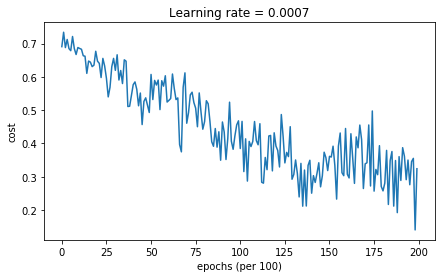

Accuracy: 0.8766666666666667


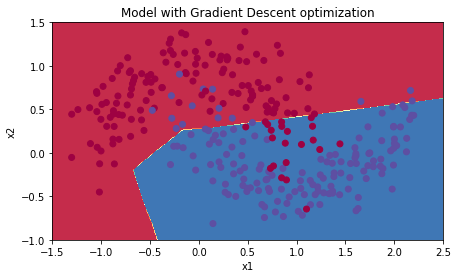

In [14]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "gd")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

### b) Mini-Batch gradient descent with momentum

Cost after epoch 0: 0.690741
Cost after epoch 1000: 0.685341
Cost after epoch 2000: 0.647145
Cost after epoch 3000: 0.619594
Cost after epoch 4000: 0.576665
Cost after epoch 5000: 0.607324
Cost after epoch 6000: 0.529476
Cost after epoch 7000: 0.460936
Cost after epoch 8000: 0.465780
Cost after epoch 9000: 0.464740
Cost after epoch 10000: 0.385268
Cost after epoch 11000: 0.396533
Cost after epoch 12000: 0.392403
Cost after epoch 13000: 0.307228
Cost after epoch 14000: 0.250762
Cost after epoch 15000: 0.361475
Cost after epoch 16000: 0.307638
Cost after epoch 17000: 0.339029
Cost after epoch 18000: 0.257704
Cost after epoch 19000: 0.289101


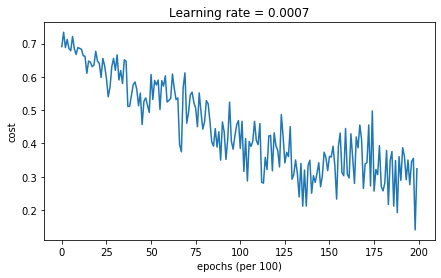

Accuracy: 0.8766666666666667


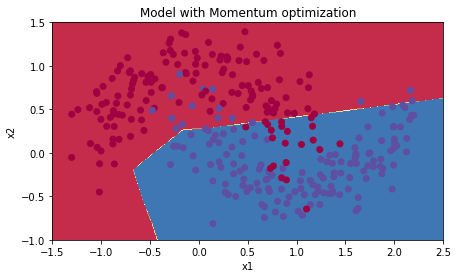

In [10]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, beta = 0.9, optimizer = "momentum")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Momentum optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

### c) Mini-batch with Adam 

In [12]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, beta = 0.9, optimizer = "adam")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Adam optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

(2, 64)
(2, 64)
(2, 64)
(2, 64)
(2, 44)
Cost after epoch 0: 0.690552
(2, 64)
(2, 64)
(2, 64)
(2, 64)
(2, 44)
(2, 64)
(2, 64)
(2, 64)
(2, 64)
(2, 44)
(2, 64)
(2, 64)
(2, 64)
(2, 64)
(2, 44)
(2, 64)
(2, 64)
(2, 64)
(2, 64)
(2, 44)
(2, 64)
(2, 64)
(2, 64)
(2, 64)
(2, 44)
(2, 64)
(2, 64)
(2, 64)
(2, 64)
(2, 44)
(2, 64)
(2, 64)
(2, 64)
(2, 64)
(2, 44)
(2, 64)
(2, 64)
(2, 64)
(2, 64)
(2, 44)
(2, 64)
(2, 64)
(2, 64)
(2, 64)
(2, 44)
(2, 64)
(2, 64)
(2, 64)
(2, 64)
(2, 44)
(2, 64)
(2, 64)
(2, 64)
(2, 64)
(2, 44)
(2, 64)
(2, 64)
(2, 64)
(2, 64)
(2, 44)
(2, 64)
(2, 64)
(2, 64)
(2, 64)
(2, 44)
(2, 64)
(2, 64)
(2, 64)
(2, 64)
(2, 44)
(2, 64)
(2, 64)
(2, 64)
(2, 64)
(2, 44)
(2, 64)
(2, 64)
(2, 64)
(2, 64)
(2, 44)
(2, 64)
(2, 64)
(2, 64)
(2, 64)
(2, 44)
(2, 64)
(2, 64)
(2, 64)
(2, 64)
(2, 44)
(2, 64)
(2, 64)
(2, 64)
(2, 64)
(2, 44)
(2, 64)
(2, 64)
(2, 64)
(2, 64)
(2, 44)
(2, 64)
(2, 64)
(2, 64)
(2, 64)
(2, 44)
(2, 64)
(2, 64)
(2, 64)
(2, 64)
(2, 44)
(2, 64)
(2, 64)
(2, 64)
(2, 64)
(2, 44)
(2, 64)
(2,

KeyboardInterrupt: 